In [ ]:
#!test ! -f "master.zip" && wget "https://github.com/karoldvl/ESC-50/archive/master.zip"

In [ ]:
#!unzip -qq master.zip

In [ ]:
#%cd ESC-50-master

In [22]:
import pyaudio
import winsound
import wave
import time
import pandas as pd
import librosa
import cv2
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
#from tqdm import tqdm_notebook as tqdm
from tqdm import tqdm, notebook
import os

In [2]:
df = pd.read_csv('meta/esc50.csv')

In [3]:
df.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [4]:
df = df.drop(df[(df.category == "dog") | (df.category == "chirping_birds") | (df.category == "thunderstorm") | (df.category == "can_opening") 
                | (df.category == "crow") | (df.category == "clapping") | (df.category == "fireworks") | (df.category == "chainsaw")
                | (df.category == "airplane") | (df.category == "mouse_click") | (df.category == "train") | (df.category == "sheep") 
               | (df.category == "church_bells") | (df.category == "clock_alarm") | (df.category == "keyboard_typing") | (df.category == "wind") 
                | (df.category == "frog") | (df.category == "cow") | (df.category == "car_horn") | (df.category == "crackling_fire") 
                | (df.category == "helicopter") | (df.category == "engine") | (df.category == "pouring_water")  | (df.category == "engine")
               | (df.category == "drinking_sipping") | (df.category == "rain") | (df.category == "insects") | (df.category == "laughing") 
               | (df.category == "hen") | (df.category == "breathing") | (df.category == "crying_baby") | (df.category == "hand_saw")
               | (df.category == "coughing")| (df.category == "insects") | (df.category == "glass_breaking") | (df.category == "snoring")
               | (df.category == "pig") | (df.category == "clock_tick") | (df.category == "footsteps") | (df.category == "rooster")
               | (df.category == "sea_waves") | (df.category == "engine") | (df.category == "sneezing") | (df.category == "siren")
               | (df.category == "cat") | (df.category == "door_wood_creaks") | (df.category == "crickets") | (df.category == "engine")
               | (df.category == "door_wood_knock")].index)
df.reset_index(inplace = True)

In [5]:
# pandas.set_option('display.max_rows', None)
print (df['category'])

0       vacuum_cleaner
1       vacuum_cleaner
2          water_drops
3          water_drops
4          water_drops
            ...       
195    washing_machine
196        water_drops
197        water_drops
198        water_drops
199     vacuum_cleaner
Name: category, Length: 200, dtype: object


In [6]:
df = df.drop(['index'], axis='columns') 
df.head(40)

,filename,fold,target,category,esc10,src_file,take
0,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
1,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
2,1-12653-A-15.wav,1,15,water_drops,False,12653,A
3,1-12654-A-15.wav,1,15,water_drops,False,12654,A
4,1-12654-B-15.wav,1,15,water_drops,False,12654,B
5,1-16746-A-15.wav,1,15,water_drops,False,16746,A
6,1-17092-A-27.wav,1,27,brushing_teeth,False,17092,A
7,1-17092-B-27.wav,1,27,brushing_teeth,False,17092,B
8,1-19840-A-36.wav,1,36,vacuum_cleaner,False,19840,A
9,1-19872-A-36.wav,1,36,vacuum_cleaner,False,19872,A


In [7]:
df.shape

(200, 7)

In [8]:
train = df[df['fold']!=5]
valid = df[df['fold']==5]

In [9]:
wav, sr = librosa.load('audio/1-20736-A-18.wav', sr=None)
print(f'Sampling rate of the audio is {sr} and length of the audio is {len(wav)/sr} seconds')

Sampling rate of the audio is 44100 and length of the audio is 5.0 seconds


In [10]:
def spec_to_image(spec, eps=1e-6):
    mean = spec.mean()
    std = spec.std()
    spec_norm = (spec - mean) / (std + eps)
    spec_min, spec_max = spec_norm.min(), spec_norm.max()
    spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
    spec_scaled = spec_scaled.astype(np.uint8)    
    return spec_scaled

In [11]:
def spec_to_image_3d(spec, eps=1e-6):
    mean = spec.mean()
    std = spec.std()
    spec_norm = (spec - mean) / (std + eps)
    spec_min, spec_max = spec_norm.min(), spec_norm.max()
    spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
    spec_scaled = spec_scaled.astype(np.uint8)
    # print (np.shape(spec_scaled))
    spec_scaled= cv2.cvtColor(spec_scaled,cv2.COLOR_GRAY2RGB)
    # print (np.shape(spec_scaled))
    return spec_scaled

In [12]:
def get_melspectrogram_db(file_path, sr=None, n_fft=2048, hop_length=512, n_mels=128, fmin=20, fmax=8300, top_db=80):
    wav,sr = librosa.load(file_path,sr=sr)
    if wav.shape[0]<5*sr:
        wav=np.pad(wav,int(np.ceil((5*sr-wav.shape[0])/2)),mode='reflect')
    else:
        wav=wav[:5*sr]
    spec=librosa.feature.melspectrogram(y= wav, sr=sr, n_fft=n_fft, hop_length=hop_length,n_mels=n_mels,fmin=fmin,fmax=fmax)
    spec_db=librosa.power_to_db(spec,top_db=top_db)
    return spec_db

In [14]:
class ESC50Data(Dataset):
    def __init__(self, base, df, in_col, out_col):
        self.df = df
        self.data = []
        self.temp = []
        self.labels = []
        self.c2i={}
        self.i2c={}
        # print (np.shape(df))        
        self.categories = sorted(df[out_col].unique())
        # print (np.shape(self.categories))
        for i, category in enumerate(self.categories):
            self.c2i[category]=i
            self.i2c[i]=category
        for ind in tqdm(range(len(df))):
            row = df.iloc[ind]
            file_path = os.path.join(base,row[in_col])
            mel= spec_to_image(get_melspectrogram_db(file_path))
            self.data.append(mel[np.newaxis,...])
            self.labels.append(self.c2i[row['category']])
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [15]:
class ESC50Data_3d(Dataset):
    def __init__(self, base, df, in_col, out_col):
        self.df = df
        self.data = []
        self.temp = []
        self.labels = []
        self.c2i={}
        self.i2c={}
        count= 0
        # print (np.shape(df))        
        self.categories = sorted(df[out_col].unique())
        # print (np.shape(self.categories))
        for i, category in enumerate(self.categories):
            self.c2i[category]=i
            self.i2c[i]=category
        for ind in tqdm(range(len(df))):
            row = df.iloc[ind]
            file_path = os.path.join(base,row[in_col])
            # print (np.shape(spec_to_image_3d(get_melspectrogram_db(file_path))[...,0]))
            # self.data.append(spec_to_image(get_melspectrogram_db(file_path))[np.newaxis,...])
            mel= spec_to_image_3d(get_melspectrogram_db(file_path))
            mel_0d= mel[...,0]
            mel_1d= mel[...,1]
            mel_2d= mel[...,2]
            self.data.append(mel_0d[np.newaxis,...])
            self.data.append(mel_1d[np.newaxis,...])
            self.data.append(mel_2d[np.newaxis,...])
            self.labels.append(self.c2i[row['category']])
            count+= 1
        self.data= np.reshape(self.data, (count,3, 128, 431))
        
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [16]:
class ESC50Model(nn.Module):
    def __init__(self, input_shape, batch_size=16, num_cats=50):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size = 3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size = 3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.bn6 = nn.BatchNorm2d(128)
        self.conv7 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn7 = nn.BatchNorm2d(256)
        self.conv8 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.bn8 = nn.BatchNorm2d(256)
        self.dense1 = nn.Linear(256*(((input_shape[1]//2)//2)//2)*(((input_shape[2]//2)//2)//2),500)
        self.dropout = nn.Dropout(0.5)
        self.dense2 = nn.Linear(500, num_cats)
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = F.max_pool2d(x, kernel_size=2) 
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv5(x)
        x = F.relu(self.bn5(x))
        x = self.conv6(x)
        x = F.relu(self.bn6(x))
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv7(x)
        x = F.relu(self.bn7(x))
        x = self.conv8(x)
        x = F.relu(self.bn8(x))
        x = x.view(x.size(0),-1)
        x = F.relu(self.dense1(x))
        x = self.dropout(x)
        x = self.dense2(x)
        return x


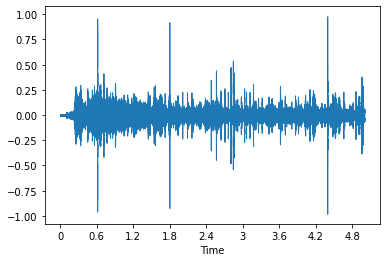

In [17]:
filename = valid[valid['category']=='toilet_flush'].iloc[0]['filename']
wav, sr = librosa.load('audio/'+filename, sr=None)
librosa.display.waveshow(wav, sr= sr)

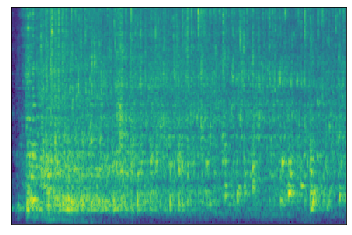

In [19]:
librosa.display.specshow(spec_to_image(get_melspectrogram_db('audio/'+filename, sr)), cmap='viridis')

In [20]:
train_data = ESC50Data('audio', train, 'filename', 'category')

100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:03<00:00, 50.04it/s]


In [21]:
print (np.shape(train_data.data))

(160, 1, 128, 431)


In [22]:
train_data_3d = ESC50Data_3d('audio', train, 'filename', 'category')

100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:03<00:00, 45.76it/s]


In [23]:
print (np.shape(train_data_3d.data))

(160, 3, 128, 431)


In [24]:
valid_data = ESC50Data('audio', valid, 'filename', 'category')

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 45.71it/s]


In [25]:
print (np.shape(valid_data.data))

(40, 1, 128, 431)


In [26]:
valid_data_3d = ESC50Data_3d('audio', valid, 'filename', 'category')

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 50.72it/s]


In [27]:
print (np.shape(valid_data_3d.data))

(40, 3, 128, 431)


In [28]:
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=16, shuffle=True)
train_loader_3d = DataLoader(train_data_3d, batch_size=16, shuffle=True)
valid_loader_3d = DataLoader(valid_data_3d, batch_size=16, shuffle=True)

In [29]:
if torch.cuda.is_available():
    device=torch.device('cuda:0')
else:
    device=torch.device('cpu')

In [30]:
model = ESC50Model(input_shape=(1,128,431), batch_size=16, num_cats=50).to(device)

In [31]:
def setlr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return optimizer

In [34]:
loss_fn = nn.CrossEntropyLoss()
learning_rate = 2e-5
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
epochs = 6
train_losses = []
valid_losses = []

In [35]:
def train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, train_losses, valid_losses, change_lr=None):
    for epoch in tqdm(range(1,epochs+1)):
        model.train()
        batch_losses=[]
        if change_lr:
            optimizer = change_lr(optimizer, epoch)
        for i, data in enumerate(train_loader):
            x, y = data
            optimizer.zero_grad()
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.long)
            y_hat = model(x)
            loss = loss_fn(y_hat, y)
            loss.backward()
            batch_losses.append(loss.item())
            optimizer.step()
        train_losses.append(batch_losses)
        print(f'Epoch - {epoch} Train-Loss : {np.mean(train_losses[-1])}')
        model.eval()
        batch_losses=[]
        trace_y = []
        trace_yhat = []
        for i, data in enumerate(valid_loader):
            x, y = data
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.long)
            y_hat = model(x)
            loss = loss_fn(y_hat, y)
            trace_y.append(y.cpu().detach().numpy())
            trace_yhat.append(y_hat.cpu().detach().numpy())      
            batch_losses.append(loss.item())
        valid_losses.append(batch_losses)
        trace_y = np.concatenate(trace_y)
        trace_yhat = np.concatenate(trace_yhat)
        accuracy = np.mean(trace_yhat.argmax(axis=1)==trace_y)
        print(f'Epoch - {epoch} Valid-Loss : {np.mean(valid_losses[-1])} Valid-Accuracy : {accuracy}')

In [36]:
def lr_decay(optimizer, epoch):
    if epoch%20==0:
        new_lr = learning_rate / (10**(epoch//20))
        optimizer = setlr(optimizer, new_lr)
        print(f'Changed learning rate to {new_lr}')
    return optimizer

train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, train_losses, valid_losses, lr_decay)

  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch - 1 Train-Loss : 2.2302610635757447


 17%|██████████████                                                                      | 1/6 [00:57<04:48, 57.67s/it]

Epoch - 1 Valid-Loss : 2.5418008963267007 Valid-Accuracy : 0.2
Epoch - 2 Train-Loss : 0.7662829905748367


 33%|████████████████████████████                                                        | 2/6 [01:59<04:00, 60.00s/it]

Epoch - 2 Valid-Loss : 1.8967994451522827 Valid-Accuracy : 0.275
Epoch - 3 Train-Loss : 0.48258721828460693


 50%|██████████████████████████████████████████                                          | 3/6 [02:56<02:56, 58.81s/it]

Epoch - 3 Valid-Loss : 2.3024179935455322 Valid-Accuracy : 0.275
Epoch - 4 Train-Loss : 0.15565061438828706


 67%|████████████████████████████████████████████████████████                            | 4/6 [03:54<01:56, 58.26s/it]

Epoch - 4 Valid-Loss : 0.8690386811892191 Valid-Accuracy : 0.675
Epoch - 5 Train-Loss : 0.0800501924008131


 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [04:50<00:57, 57.55s/it]

Epoch - 5 Valid-Loss : 0.5486640830834707 Valid-Accuracy : 0.85
Epoch - 6 Train-Loss : 0.05800482574850321


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [05:47<00:00, 57.88s/it]

Epoch - 6 Valid-Loss : 0.7240700225035349 Valid-Accuracy : 0.8


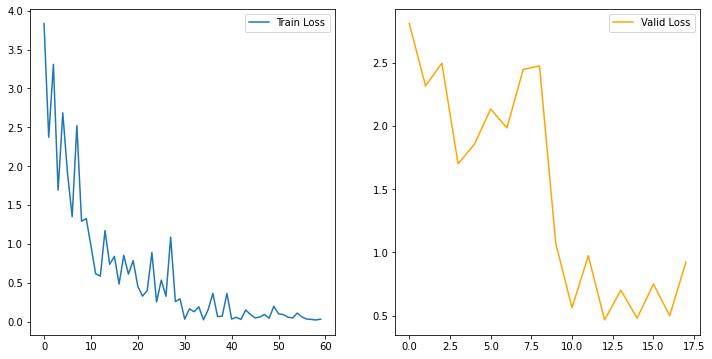

In [37]:
tl = np.asarray(train_losses).ravel()
vl = np.asarray(valid_losses).ravel()
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(tl)
plt.legend(['Train Loss'])
plt.subplot(1,2,2)
plt.plot(vl,'orange')
plt.legend(['Valid Loss'])


In [ ]:
from torchvision.models import resnet34, ResNet34_Weights
weights = ResNet34_Weights.DEFAULT
resnet_model = resnet34(weights=weights)
resnet_model.fc = nn.Linear(512,50)
resnet_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
resnet_model = resnet_model.to(device)

In [ ]:
learning_rate = 2e-4
optimizer = optim.Adam(resnet_model.parameters(), lr=learning_rate)
epochs = 5
loss_fn = nn.CrossEntropyLoss()
resnet_train_losses=[]
resnet_valid_losses=[]
def lr_decay(optimizer, epoch):
    if epoch%10==0:
        new_lr = learning_rate / (10**(epoch//10))
        optimizer = setlr(optimizer, new_lr)
        print(f'Changed learning rate to {new_lr}')
    return optimizer

train(resnet_model, loss_fn, train_loader, valid_loader, epochs, optimizer, resnet_train_losses, resnet_valid_losses, lr_decay)

In [ ]:
tl = np.asarray(resnet_train_losses).ravel()
vl = np.asarray(resnet_valid_losses).ravel()
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(tl)
plt.legend(['Train Loss'])
plt.subplot(1,2,2)
plt.plot(vl,'orange')
plt.legend(['Valid Loss'])


In [38]:
from torchvision.models import resnet50, ResNet50_Weights
weights = ResNet50_Weights.DEFAULT
resnet_model_50 = resnet50(weights=weights)
resnet_model_50.fc = nn.Linear(2048,16)
resnet_model_50.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
resnet_model_50 = resnet_model_50.to(device)

In [39]:
learning_rate = 2e-4
optimizer = optim.Adam(resnet_model_50.parameters(), lr=learning_rate)
epochs = 6
loss_fn = nn.CrossEntropyLoss()
resnet_50_train_losses=[]
resnet_50_valid_losses=[]
def lr_decay(optimizer, epoch):
    if epoch%10==0:
        new_lr = learning_rate / (10**(epoch//10))
        optimizer = setlr(optimizer, new_lr)
        print(f'Changed learning rate to {new_lr}')
    return optimizer

train(resnet_model_50, loss_fn, train_loader, valid_loader, epochs, optimizer, resnet_50_train_losses, resnet_50_valid_losses, lr_decay)

  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch - 1 Train-Loss : 2.1875529527664184


 17%|██████████████                                                                      | 1/6 [01:22<06:50, 82.14s/it]

Epoch - 1 Valid-Loss : 2.1068620681762695 Valid-Accuracy : 0.4
Epoch - 2 Train-Loss : 0.8192247867584228


 33%|████████████████████████████                                                        | 2/6 [02:41<05:21, 80.31s/it]

Epoch - 2 Valid-Loss : 0.8598062594731649 Valid-Accuracy : 0.775
Epoch - 3 Train-Loss : 0.2840304754674435


 50%|██████████████████████████████████████████                                          | 3/6 [04:00<03:59, 79.73s/it]

Epoch - 3 Valid-Loss : 0.48029078046480816 Valid-Accuracy : 0.825
Epoch - 4 Train-Loss : 0.18943428099155427


 67%|████████████████████████████████████████████████████████                            | 4/6 [05:20<02:39, 79.93s/it]

Epoch - 4 Valid-Loss : 0.7263031005859375 Valid-Accuracy : 0.725
Epoch - 5 Train-Loss : 0.1289739992469549


 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [06:39<01:19, 79.57s/it]

Epoch - 5 Valid-Loss : 0.7075313925743103 Valid-Accuracy : 0.775
Epoch - 6 Train-Loss : 0.04987796805799007


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [08:02<00:00, 80.37s/it]

Epoch - 6 Valid-Loss : 0.712191641330719 Valid-Accuracy : 0.825


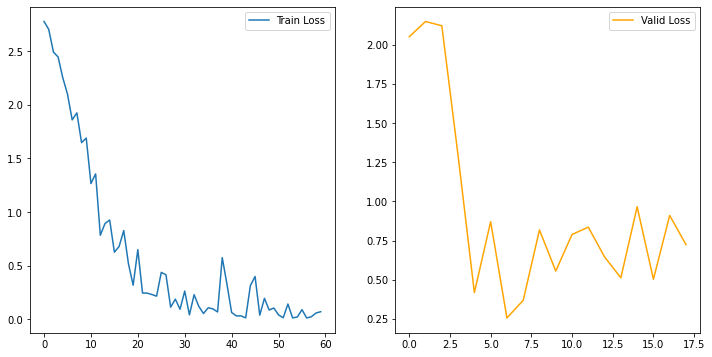

In [41]:
tl = np.asarray(resnet_50_train_losses).ravel()
vl = np.asarray(resnet_50_valid_losses).ravel()
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(tl)
plt.legend(['Train Loss'])
plt.subplot(1,2,2)
plt.plot(vl,'orange')
plt.legend(['Valid Loss'])


In [42]:
from torchvision.models import densenet201, DenseNet201_Weights
weights = DenseNet201_Weights.DEFAULT
densenet_model_201 = densenet201(weights=weights)
densenet_model_201.fc = nn.Linear(2048,16)
densenet_model_201.conv1 = nn.Conv2d(1, 16, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
densenet_model_201 = densenet_model_201.to(device)

In [43]:
learning_rate = 2e-4
optimizer = optim.Adam(densenet_model_201.parameters(), lr=learning_rate)
epochs = 6
loss_fn = nn.CrossEntropyLoss()
densenet_201_train_losses=[]
densenet_201_valid_losses=[]
def lr_decay(optimizer, epoch):
    if epoch%10==0:
        new_lr = learning_rate / (10**(epoch//10))
        optimizer = setlr(optimizer, new_lr)
        print(f'Changed learning rate to {new_lr}')
    return optimizer

train(densenet_model_201, loss_fn, train_loader_3d, valid_loader_3d, epochs, optimizer, densenet_201_train_losses, densenet_201_valid_losses, lr_decay)

  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch - 1 Train-Loss : 4.181683886051178


 17%|█████████████▊                                                                     | 1/6 [01:53<09:28, 113.61s/it]

Epoch - 1 Valid-Loss : 3.65958301226298 Valid-Accuracy : 0.4
Epoch - 2 Train-Loss : 0.4316864419728518


 33%|███████████████████████████▋                                                       | 2/6 [03:49<07:39, 114.87s/it]

Epoch - 2 Valid-Loss : 1.2154667377471924 Valid-Accuracy : 0.75
Epoch - 3 Train-Loss : 0.11142580900341273


 50%|█████████████████████████████████████████▌                                         | 3/6 [05:45<05:46, 115.48s/it]

Epoch - 3 Valid-Loss : 0.7508120536804199 Valid-Accuracy : 0.875
Epoch - 4 Train-Loss : 0.09189393863780423


 67%|███████████████████████████████████████████████████████▎                           | 4/6 [07:40<03:50, 115.45s/it]

Epoch - 4 Valid-Loss : 0.8476579586664835 Valid-Accuracy : 0.9
Epoch - 5 Train-Loss : 0.13861584145925007


 83%|█████████████████████████████████████████████████████████████████████▏             | 5/6 [09:41<01:57, 117.27s/it]

Epoch - 5 Valid-Loss : 0.5312496175368627 Valid-Accuracy : 0.9
Epoch - 6 Train-Loss : 0.10444169996771961


100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [11:38<00:00, 116.41s/it]

Epoch - 6 Valid-Loss : 0.7489312688509623 Valid-Accuracy : 0.875


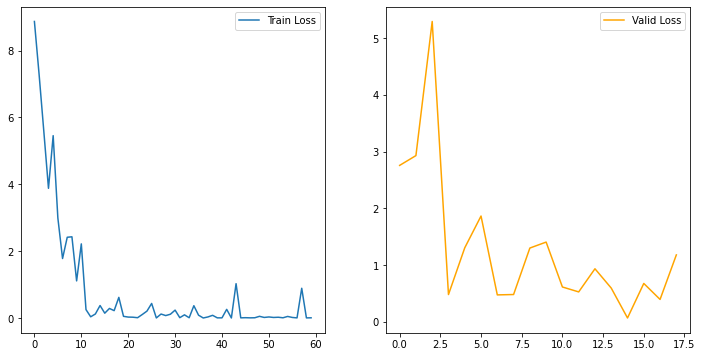

In [44]:
tl = np.asarray(densenet_201_train_losses).ravel()
vl = np.asarray(densenet_201_valid_losses).ravel()
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(tl)
plt.legend(['Train Loss'])
plt.subplot(1,2,2)
plt.plot(vl,'orange')
plt.legend(['Valid Loss'])


In [49]:
from torchvision.models import efficientnet_v2_l, EfficientNet_V2_L_Weights
weights = EfficientNet_V2_L_Weights.DEFAULT
efficientnet_b7_model = efficientnet_v2_l(weights=weights)
efficientnet_b7_model.fc = nn.Linear(2048,16)
efficientnet_b7_model.conv1 = nn.Conv2d(1, 16, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
efficientnet_b7_model = efficientnet_b7_model.to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_l-59c71312.pth" to C:\Users\User/.cache\torch\hub\checkpoints\efficientnet_v2_l-59c71312.pth


  0%|          | 0.00/455M [00:00<?, ?B/s]

In [50]:
learning_rate = 2e-4
optimizer = optim.Adam(efficientnet_b7_model.parameters(), lr=learning_rate)
epochs = 6
loss_fn = nn.CrossEntropyLoss()
efficientnet_b7_train_losses=[]
efficientnet_b7_valid_losses=[]
def lr_decay(optimizer, epoch):
    if epoch%10==0:
        new_lr = learning_rate / (10**(epoch//10))
        optimizer = setlr(optimizer, new_lr)
        print(f'Changed learning rate to {new_lr}')
    return optimizer

train(efficientnet_b7_model, loss_fn, train_loader_3d, valid_loader_3d, epochs, optimizer, efficientnet_b7_train_losses, efficientnet_b7_valid_losses, lr_decay)

  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch - 1 Train-Loss : 4.65971531867981


 17%|█████████████▊                                                                     | 1/6 [05:07<25:35, 307.12s/it]

Epoch - 1 Valid-Loss : 4.868887583414714 Valid-Accuracy : 0.2
Epoch - 2 Train-Loss : 0.6849210150539875


 33%|███████████████████████████▋                                                       | 2/6 [10:20<20:43, 310.88s/it]

Epoch - 2 Valid-Loss : 1.6078826586405437 Valid-Accuracy : 0.725
Epoch - 3 Train-Loss : 0.409000763297081


 50%|█████████████████████████████████████████▌                                         | 3/6 [15:38<15:41, 313.90s/it]

Epoch - 3 Valid-Loss : 0.6506068011124929 Valid-Accuracy : 0.85
Epoch - 4 Train-Loss : 0.28001676592975855


 67%|███████████████████████████████████████████████████████▎                           | 4/6 [20:49<10:26, 313.07s/it]

Epoch - 4 Valid-Loss : 0.7581764757633209 Valid-Accuracy : 0.9
Epoch - 5 Train-Loss : 0.13216054998338223


 83%|█████████████████████████████████████████████████████████████████████▏             | 5/6 [26:09<05:15, 315.47s/it]

Epoch - 5 Valid-Loss : 0.6185173988342285 Valid-Accuracy : 0.9
Epoch - 6 Train-Loss : 0.16622382011264564


100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [31:24<00:00, 314.06s/it]

Epoch - 6 Valid-Loss : 0.4480011217528954 Valid-Accuracy : 0.875


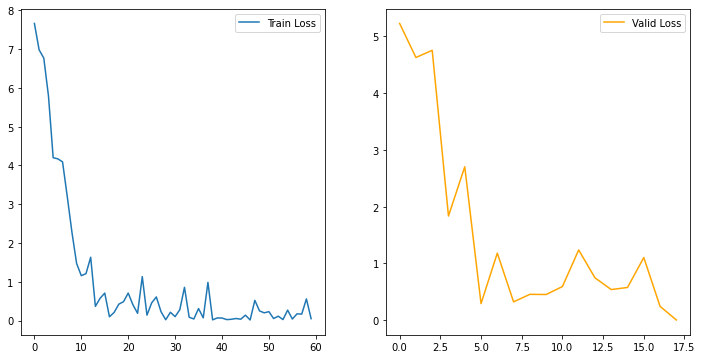

In [51]:
tl = np.asarray(efficientnet_b7_train_losses).ravel()
vl = np.asarray(efficientnet_b7_valid_losses).ravel()
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(tl)
plt.legend(['Train Loss'])
plt.subplot(1,2,2)
plt.plot(vl,'orange')
plt.legend(['Valid Loss'])


In [ ]:
with open('esc50resnet.pth','wb') as f:
  torch.save(resnet_model, f)

In [ ]:
import pickle
with open('indtocat.pkl','wb') as f:
  pickle.dump(train_data.i2c, f)

In [ ]:
from google.colab import drive
!mkdir gdrive
drive.mount('gdrive')
!cp esc50resnet.pth gdrive/My\ Drive/
!cp indtocat.pkl gdrive/My\ Drive/

In [ ]:
import IPython
with open('indtocat.pkl','rb') as f:
  indtocat = pickle.load(f)
filename='/content/ESC-50-master/audio/1-116765-A-41.wav'
spec=spec_to_image(get_melspectrogram_db(filename))
spec_t=torch.tensor(spec).to(device, dtype=torch.float32)
pr=resnet_model.forward(spec_t.reshape(1,1,*spec_t.shape))
ind = pr.argmax(dim=1).cpu().detach().numpy().ravel()[0]
print(indtocat[ind])
IPython.display.display(IPython.display.Audio(filename=filename))

In [ ]:
!wget 'http://soundbible.com/grab.php?id=2215&type=wav' -O "dog.wav"
filename='dog.wav'
spec=spec_to_image(get_melspectrogram_db(filename))
spec_t=torch.tensor(spec).to(device, dtype=torch.float32)
pr=resnet_model.forward(spec_t.reshape(1,1,*spec_t.shape))
ind = pr.argmax(dim=1).cpu().detach().numpy().ravel()[0]
print(indtocat[ind])
IPython.display.display(IPython.display.Audio(filename=filename))

In [ ]:
!wget "http://soundbible.com/grab.php?id=1954&type=wav" -O "cat.wav"
filename='cat.wav'
spec=spec_to_image(get_melspectrogram_db(filename))
spec_t=torch.tensor(spec).to(device, dtype=torch.float32)
pr=resnet_model.forward(spec_t.reshape(1,1,*spec_t.shape))
ind = pr.argmax(dim=1).cpu().detach().numpy().ravel()[0]
print(indtocat[ind])
IPython.display.display(IPython.display.Audio(filename=filename))